## Accelerate Inference: Neural Network Pruning

In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

import pickle
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.layers import *

from google.colab import files
print(tf.version.VERSION)

2.7.0


In [4]:
# untar
!tar -xvzf dataset.tar.gz
# load train
train_images = pickle.load(open('train_images.pkl', 'rb'))
train_labels = pickle.load(open('train_labels.pkl', 'rb'))
# load val
val_images = pickle.load(open('val_images.pkl', 'rb'))
val_labels = pickle.load(open('val_labels.pkl', 'rb'))

train_images.pkl
train_labels.pkl
val_images.pkl
val_labels.pkl


In [5]:
# Define the neural network architecture (don't change this)

model = models.Sequential()
model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-5), input_shape=(25,25,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(1e-5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-5)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(1e-5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))

In [6]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 32)        896       
                                                                 
 activation (Activation)     (None, 25, 25, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 23, 23, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 11, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 11, 32)        0         
                                                        

In [7]:
# you can use the default hyper-parameters for training, 
# and val accuracy ~59% after 25 epochs and > 63% after 50 epochs

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# history = model.fit(train_images, train_labels, batch_size=32, epochs=200, 
#                     validation_data=(val_images, val_labels)) # train for 50 epochs, with batch size 32

In [8]:
model.load_weights('uncompressed_model_weights.h5')##Upload Uncompressed model weights
weights = model.get_weights()
results = model.evaluate(val_images, val_labels, batch_size=128)##Accuracy for Uncompressed Model
assert results[1]>0.76##Validation accuracy of the uncompressed model needs to be atleast 76%
uncompressed_weights = model.get_weights()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


20/20 [==============================] - 11s 14ms/step - loss: 0.9843 - accuracy: 0.7671


In [9]:
# Global Thresholding
model.set_weights(uncompressed_weights)
def thres2accu(weights,model,t=10):
    sparsity_candidate_layer = [0,2,4,6,8,10]
    tr_weights = np.copy(weights)
    stacked_wts = np.hstack([i.flatten() for i in weights])
    thres = np.percentile(np.abs(stacked_wts),t)
    for i in range(len(weights)):
      # if i in sparsity_candidate_layer:
        tr = np.abs(weights[i])>thres
        tr_weights[i] = np.multiply(weights[i],tr)
    model.set_weights(tr_weights)
    results = model.evaluate(val_images, val_labels, batch_size=128,verbose=0)
    return results[1], tr_weights


thres_list = np.arange(0,100,1)
accu_list = []
score = 0
acc = 0
spar = 0
for i in thres_list:
    accu,weight_candidate=thres2accu(weights,model,t=i)
    accu_list.append(accu)
    if accu>0.6:
      score_candidate = (i/100+accu)/2
      if score_candidate>score:
        score=score_candidate
        tr_weights=weight_candidate
        acc=accu
        spar=i
print('Max Score: ', score)
print('Accuracy: ', acc)
print('Sparcity: ',spar,'%')
model.set_weights(tr_weights)
thres_list2 = np.copy(thres_list)
accu_list2 = np.copy(accu_list)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


Max Score:  0.6355940532684325
Accuracy:  0.6811881065368652
Sparcity:  59 %


In [10]:
model.save_weights('Global_thres_weights.h5')
files.download('Global_thres_weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


Max Score:  0.5503960466384887
Accuracy:  0.6807920932769775
Sparcity:  42 %


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

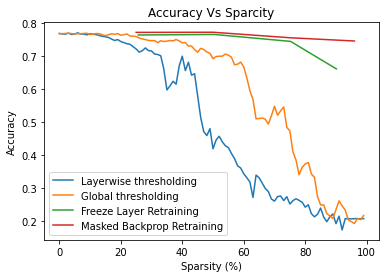

In [12]:
#Layerwise Thresholding
model.set_weights(uncompressed_weights)
def thres2accu(weights,model,t=10):
    sparsity_candidate_layer = [0,2,4,6,8,10]
    tr_weights = np.copy(weights)
    for i in range(len(weights)):
      # if i in sparsity_candidate_layer:
        thres = np.percentile(np.abs(weights[i]),t)
        tr = np.abs(weights[i])>thres
        tr_weights[i] = np.multiply(weights[i],tr)
    model.set_weights(tr_weights)
    results = model.evaluate(val_images, val_labels, batch_size=128,verbose=0)
    return results[1], tr_weights

thres_list = np.arange(0,100,1)
accu_list = []
score = 0
acc = 0
spar = 0
for i in thres_list:
    accu,weight_candidate=thres2accu(weights,model,t=i)
    accu_list.append(accu)
    if accu>0.6:
      score_candidate = (i/100+accu)/2
      if score_candidate>score:
        score=score_candidate
        tr_weights=weight_candidate
        acc=accu
        spar=i
print('Max Score: ', score)
print('Accuracy: ', acc)
print('Sparcity: ',spar,'%')
model.set_weights(tr_weights)
model.save_weights('Layerwise_thres_weights.h5')
files.download('Layerwise_thres_weights.h5')

plt.plot(thres_list,accu_list,label = 'Layerwise thresholding')
plt.plot(thres_list2,accu_list2,label = 'Global thresholding')
plt.plot([25.667824189242294, 50.4502195020348, 75.2326148148273, 90.11524067643393],[0.7631683349609375, 0.7647524476051331, 0.7437623739242554, 0.6605940461158752],label = 'Freeze Layer Retraining')
plt.plot([25,50,75,96],[0.7710891366004944,0.7714851498603821,0.7548514604568481,0.7449504733085632],label = 'Masked Backprop Retraining')
plt.title("Accuracy Vs Sparcity")
plt.xlabel('Sparsity (%)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()